# All Regression Notebook
## Load dữ liệu
Khai báo và load thư viện, sau đó load tập dữ liệu. Do tập dữ liệu không chứa tên cột nên chúng ta cần thêm nó vào bằng cách sử dụng list Python thủ công. 

Chúng ta có `all_train_data` và `all_test_data` đã được nối vào `DataFrame` tương ứng.

In [20]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

columns_name = ["Popularity", "Check-in", "Activities", "Category"] \
            + ["F_{:d}".format(i) for i in range(1, 26)] \
            + ["CC{:d}".format(i) for i in range(1, 6)] \
            + ["Base time", "Post length", "Post count", "Post promotion", "Span time"] \
            + ["Post_date_{:d}".format(i) for i in range(1, 8)] \
            + ["Base_date_{:d}".format(i) for i in range(1, 8)] \
            + ["Span count"]
all_train_data = [pandas.read_csv("./Dataset/Training/Features_Variant_{:d}.csv".format(d), header=None) for d in range(1, 6)]
for data in all_train_data:
    print("Train sets size: {:d}".format(data.size))
# Viết code nối dữ liệu huấn luyện
train_data = pandas.concat(all_train_data,ignore_index=True)
train_data.columns = columns_name

all_test_data = [pandas.read_csv("./Dataset/Testing/TestSet/Test_Case_{:d}.csv".format(d), header=None) for d in range(1, 10)]
# Viết code nối dữ liệu kiểm tra
test_data = pandas.concat(all_test_data,ignore_index=True)
test_data.columns = columns_name

train_data["bias"] = 1
test_data["bias"] = 1

train_data.head()

Train sets size: 2211246
Train sets size: 4390848
Train sets size: 6539292
Train sets size: 8662896
Train sets size: 10747620


,Popularity,Check-in,Activities,Category,F_1,F_2,F_3,F_4,F_5,F_6,...,Post_date_7,Base_date_1,Base_date_2,Base_date_3,Base_date_4,Base_date_5,Base_date_6,Base_date_7,Span count,bias
0,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,0,0,0,0,0,1,0,1
1,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,0,0,0,0,1,0,0,1
2,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,0,0,0,0,0,1,0,1
3,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,1,0,0,0,0,0,0,1
4,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,0,0,1,0,0,0,0,1


## Lựa chọn hạng mục phụ
Cột Category chứa các index bất kỳ của hạng mục dữ liệu liên quan tới bản chất của chính bài đăng. Để đơn giản, chúng ta sẽ sử dụng hạng mục có lượng dữ liệu lớn nhất để thực hiện Hồi quy Tuyến tính.

Tìm và lựa chọn hạng mục có nhiều bản ghi nhất sử dụng pandas. Lưu nó trong biến `largest_category`

In [21]:
# Viết code ở đây:
df_groupby = train_data.groupby(['Category'], sort=False).size().reset_index(name='Count')
max_sample = df_groupby['Count'].max()
largest_category = df_groupby['Category'].loc[df_groupby['Count'] == max_sample].iloc[0]
largest_category 

9

In [22]:
# Phân hạng các mô hình
train_data = train_data.loc[train_data['Category'] == largest_category].drop('Category', axis=1)
test_data = test_data.loc[test_data['Category'] == largest_category].drop('Category', axis=1)

label = "Span count"
features = [col for col in train_data.columns if col != label]

train_features = train_data[ features ]
train_labels = train_data[ label ]
test_features = test_data[ features ]
test_labels = test_data[ label ]

## Tương quan cơ bản
Chúng ta sẽ vẽ ma trận tương quan giữa các biến CC. Tương quan rất hữu ích để xem liệu các đặc trưng có kết nối quá chặt chẽ không -  chúng ta không muốn chúng cùng nhau vì chúng sẽ tạo ra nhiễu giả gây overfit mô hình.

<AxesSubplot:>

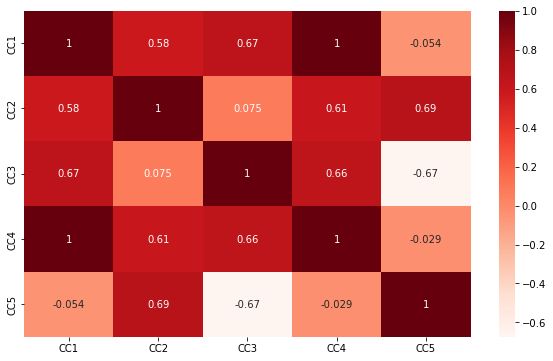

In [23]:
# Viết code ở đây:
import seaborn as sns
options = ['CC1','CC2','CC3','CC4','CC5']
corr = train_features[options].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, cmap=plt.cm.Reds, annot=True)



## Xây dựng mô hình Hồi quy

__Nhiệm vụ của chúng ta là dự đoán số lượng bình luận bài đăng sẽ nhận được (cột "Span count")__ <br>
"Span time" thì cần thiết trong khi tất cả các cột khác tùy chọn. <br>
Thử mô hình Hồi quy đa biến đơn giản chỉ có các đặc trưng cơ bản: <br>
["Popularity", "Base time", "Post length", "Post count", "Span time", "bias"]. <br>

In ra hệ số MSE từ sklearn hoặc RSS từ khóa học cho cả tập huấn luyện và tập kiểm tra.

In [24]:
# Viết code ở đây:
%time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

model_1_features = ["Popularity", "Base time", "Post length", "Post count", "Span time", "bias"]

scaler = StandardScaler()
train_features_v1 = scaler.fit_transform(train_features[model_1_features].values)
test_features_v1 = scaler.transform(test_features[model_1_features].values)

lin_reg = LinearRegression()
lin_reg.fit(train_features_v1, train_labels)

train_mse_score = mean_squared_error(train_labels, lin_reg.predict(train_features_v1))
lin_predict = lin_reg.predict(test_features_v1)
test_mse_score = mean_squared_error(test_labels, lin_predict)
print("MSE on training: {:.4f}; MSE on test: {:.4f}".format(train_mse_score, test_mse_score))


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs
MSE on training: 1689.5665; MSE on test: 5340.5897


### Hãy thử cải thiện với nhiều đặc trưng hơn
Không phải mô hình tốt nhất chúng ta có thể sử dụng. Chúng ta có thể thử thêm nhiều đặc trưng liên quan. <br>Nối tất cả các thuộc tính CC vào các đặc trưng và thử lại với cùng số liệu.

In [25]:
# Viết code ở đây:
%time
model_2_features = model_1_features + ['CC1','CC2','CC3','CC4','CC5']
scaler = StandardScaler()
train_features_v2 = scaler.fit_transform(train_features[model_2_features].values)
test_features_v2 = scaler.transform(test_features[model_2_features].values)
lin_reg_v2 = LinearRegression()
lin_reg_v2.fit(train_features_v2, train_labels)

train_mse_score = mean_squared_error(train_labels, lin_reg_v2.predict(train_features_v2))
lin_predict = lin_reg_v2.predict(test_features_v2)
test_mse_score = mean_squared_error(test_labels, lin_predict)
print("MSE on training: {:.4f}; MSE on test: {:.4f}".format(train_mse_score, test_mse_score))


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10.3 µs
MSE on training: 1535.1723; MSE on test: 3923.2827


Bài học rút ra: Tối ưu hóa sớm hiếm khi hữu ích. 

## Giải quyết overfit
### Áp dụng cách giải cho overfit

Sự khác biệt về hệ số huấn luyện và kiểm tra chỉ ra mô hình có thể overfitting. Hãy thử sửa chữa. Mở rộng hồi quy [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) (cv = 10) với alpha dọc theo logspace giữa 0 và 10, ghi nhận giá trị có chất lượng tốt nhất thành biến `best_alpha`, và *có thể tùy chọn vẽ một đồ thị cho độ lớn của các hệ số*.

In [47]:
# Viết code ở đây:
%time
from sklearn.linear_model import RidgeCV

alphas = np.logspace(0, 10)
errors = []
coefs = []
for a in alphas:
  ridge_cv_v1 = RidgeCV(alphas =[a], cv=10)
  ridge_cv_v1.fit(train_features_v2, train_labels)
  coefs.append(ridge_cv_v1.coef_)
  errors.append(mean_squared_error(test_labels, ridge_cv_v1.predict(test_features_v2)))

best_alpha = alphas[np.argmin(errors)]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


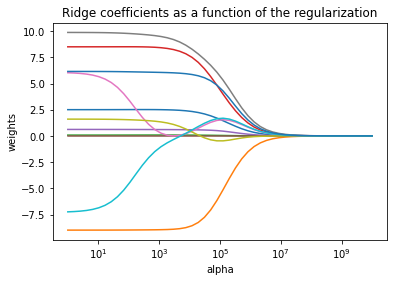

In [48]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
# ax.set_xlim(ax.get_xlim()[::-1]) #reverse
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

In [49]:
# ridge_cv_tuned: dung best alpha co duoc sau tim kiem bang RidgeCV
ridge_cv_tuned = RidgeCV(alphas=[best_alpha], cv=10)
ridge_cv_tuned.fit(train_features_v2,train_labels)
test_predictions = ridge_cv_tuned.predict(test_features_v2)

test_mse_score = mean_squared_error(test_labels, test_predictions)
train_mse_score = mean_squared_error(train_labels, ridge_cv_tuned.predict(train_features_v2))
print("MSE on training: {:.4f}; MSE on test: {:.4f}".format(train_mse_score, test_mse_score))

MSE on training: 1575.9492; MSE on test: 3760.7190


### Thử Hồi quy RidgeCV trên mọi cột
Nó đã hoạt động, nhưng chúng ta cần tự hỏi liệu có tiếp tục sử dụng tập đặc trưng không hoàn thiện thay vì một tập hợp tối ưu nữa không. Mở rộng các đặc trưng cho tất cả các cột trừ nhãn được chỉ định. Hãy chạy và xem điều gì sẽ xảy ra.

In [29]:
# Viết code ở đây:
%time
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

label = "Span count"
features = [col for col in train_data.columns if col != label]

train_features = train_data[ features ]
train_labels = train_data[ label ]
test_features = test_data[ features ]
test_labels = test_data[ label ]

scaler = StandardScaler()

train_features = scaler.fit_transform(train_features.values)
test_features = scaler.transform(test_features.values)

multi_model = RidgeCV(alphas=[best_alpha], cv=10)
multi_model.fit(train_features,train_labels)
test_predictions = multi_model.predict(test_features)

test_mse_score = mean_squared_error(test_labels, test_predictions)
train_mse_score = mean_squared_error(train_labels, multi_model.predict(train_features))
print("MSE on training: {:.4f}; MSE on test: {:.4f}".format(train_mse_score, test_mse_score))

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 5.25 µs
MSE on training: 1556.3625; MSE on test: 3892.1797


## Lựa chọn đặc trưng
### Áp dụng LASSO
Chúng ta có thể cắt tỉa các đặc trưng sử dụng những gì đã học. Lần này sẽ ghi lại các đặc trưng đã chọn của [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) (cv = 10) sử dụng biến `lasso_selected_features`, và <i>có thể tùy chọn vẽ một đồ thị giữa số lượng đặc trưng đã loại và các giá trị alpha</i>.

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs
MSE on training: 1522.9144; MSE on test: 4072.2761
Features selected by SelectFromModel: Index(['CC2', 'Base time'], dtype='object')
Features with coefficients shrank to zero:45


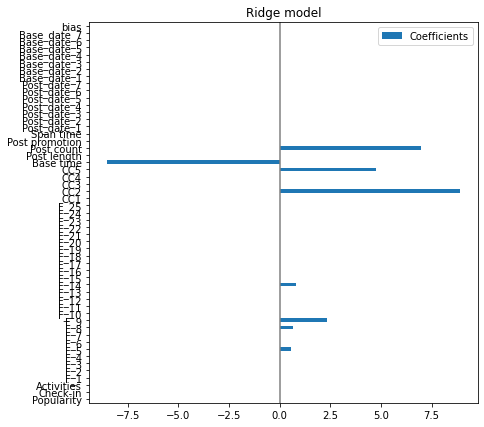

In [41]:
# Viết code ở đây:
%time
from sklearn.linear_model import LassoCV, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline

#recreate dataset
label = "Span count"
features = [col for col in train_data.columns if col != label]

train_features = train_data[ features ]
train_labels = train_data[ label ]
test_features = test_data[ features ]
test_labels = test_data[ label ]
train_col_name = train_features.columns

scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

#params of model
alphas = np.logspace(0, 10)
lasso_cv_model = LassoCV(alphas= alphas,cv=10)
lasso_cv_model.fit(train_features, train_labels)
lasso_tuned = Lasso(alpha=lasso_cv_model.alpha_)
lasso_tuned.fit(train_features, train_labels)

y_predictions = lasso_tuned.predict(test_features)
test_mse_score = mean_squared_error(test_labels, y_predictions)
train_mse_score = mean_squared_error(train_labels, lasso_tuned.predict(train_features))
print("MSE on training: {:.4f}; MSE on test: {:.4f}".format(train_mse_score, test_mse_score))

#choose threshold for selection, plot 
importance = np.abs(lasso_tuned.coef_)
threshold = np.sort(importance)[-3] + 0.01
sfm = SelectFromModel(lasso_tuned, threshold=threshold).fit(train_features, train_labels)
lasso_selected_features = train_col_name[sfm.get_support()]
print(f"Features selected by SelectFromModel: {lasso_selected_features}")
print('Features with coefficients shrank to zero:{}'.format(np.sum(sfm.estimator_.coef_==0)))

coefs = pandas.DataFrame(
   sfm.estimator_.coef_,
   columns=['Coefficients'], index=train_col_name
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

In [42]:
lasso_selected_features = lasso_selected_features.tolist()
lasso_selected_features

['CC2', 'Base time']

### Xây dựng mô hình chặt chẽ hơn với các đặc trưng đã chọn
Khi thực hiện lựa chọn đặc trưng, chúng ta có thể sẽ phải thêm lại độ chệch vào list các đặc trưng. Hãy sử dụng các đặc trưng đã chọn để xây dựng mô hình và tính toán chất lượng dựa trên các chỉ số.

In [43]:
if("bias" not in lasso_selected_features):
    lasso_selected_features.append('bias')


In [44]:
# Viết code ở đây:
%time
label = "Span count"
features = [col for col in train_data.columns if col != label]

train_features = train_data[ lasso_selected_features ]
test_features = test_data[ lasso_selected_features ]

scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

multi_model = LinearRegression().fit(train_features, train_labels)

test_predictions = multi_model.predict(test_features)
mse_test_score = mean_squared_error(test_labels, test_predictions)
mse_train_score = mean_squared_error(train_labels, multi_model.predict(train_features))
print("Train MSE: {:.4f}, Test MSE: {:.4f}".format(mse_train_score , mse_test_score))

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 14.5 µs
Train MSE: 1598.9992, Test MSE: 3783.8912


## Kết hợp mọi thứ trên một mô hình
LASSO đã thực hiện rất tốt, thu nhỏ các đặc trưng nhiễu và không cần thiết, tăng tốc độ tính toán. Bây giờ hãy kết hợp cả 2 kỹ thuật trước đó vào cùng một mô hình.

In [45]:
# Viết code ở đây:
%time
scaler = StandardScaler()

label = "Span count"
features = [col for col in train_data.columns if col != label]

train_features = train_data[ lasso_selected_features ]
test_features = test_data[ lasso_selected_features ]

train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

alphas = np.logspace(0, 10)
rid_cv_v2 = RidgeCV(alphas=alphas, cv=10).fit(train_features,train_labels)
alpha_tuned = rid_cv_v2.alpha_
rid_v2_tuned = RidgeCV(alphas=[alpha_tuned]).fit(train_features, train_labels)

test_predictions = rid_v2_tuned.predict(test_features)

test_mse_score = mean_squared_error(test_labels, test_predictions)
train_mse_score = mean_squared_error(train_labels, rid_v2_tuned.predict(train_features))
print("MSE on training: {:.4f}; MSE on test: {:.4f}".format(train_mse_score, test_mse_score))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.5 µs
MSE on training: 1598.9992; MSE on test: 3783.8805


### Phân phối sai số bình phương
Chúng ta hãy đưa ra kết luận; lưu ý thêm, hãy quan sát cách các sai số bình phương được phân phối.

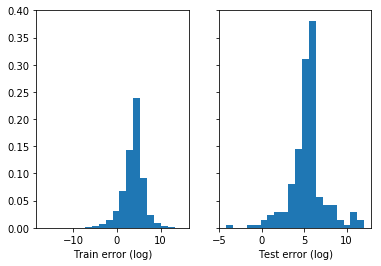

In [ ]:
train_square_errors = np.log( (train_labels - multi_model.predict(train_features)) ** 2 )
test_square_errors = np.log( (test_labels - test_predictions) ** 2 )
fig, (train_ax, test_ax) = plt.subplots(ncols=2, sharey=True)
train_ax.hist(train_square_errors, bins=20, density=True)
train_ax.set_xlabel("Train error (log)")
test_ax.set_xlabel("Test error (log)")
test_ax.hist(test_square_errors, bins=20, density=True)
plt.show()

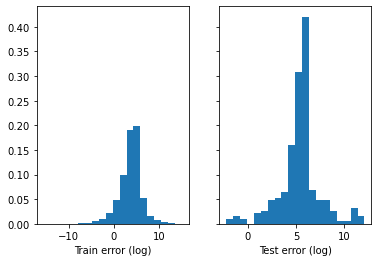

In [46]:
#code hoc vien
train_square_errors = np.log( (train_labels - rid_v2_tuned.predict(train_features)) ** 2 )
test_square_errors = np.log( (test_labels - test_predictions) ** 2 )
fig, (train_ax, test_ax) = plt.subplots(ncols=2, sharey=True)
train_ax.hist(train_square_errors, bins=20, density=True)
train_ax.set_xlabel("Train error (log)")
test_ax.set_xlabel("Test error (log)")
test_ax.hist(test_square_errors, bins=20, density=True)
plt.show()